# Training EIANN networks

:::{note}
🚧 **Work in Progress:** This documentation site is currently under construction. Content may change frequently.
:::

Once an network has been constructed using EIANN, training just requires loading the dataset and specifying a few additional parameters. For this example, we will train a conventional feedforward neural network to classify MNIST handwritten digits.


In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

import EIANN.EIANN as eiann
from EIANN import utils as ut
eiann.plot.update_plot_defaults()

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Loading the dataset

We will start by loading the dataset into a pytorch "DataLoader" object. To facilitate both analysis and reproducibility, the training function of EIANN has been designed to expect data samples that have a unique index for each sample, in addition to the features and labels. In other words, each sample is a tuple of the form (index, input data, output target). Before creating the DataLoader object, we will repackage the MNIST dataset into this format:

In [2]:
# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
root_dir = ut.get_project_root()
MNIST_train_dataset = torchvision.datasets.MNIST(root=f"{root_dir}/EIANN/data/datasets/", train=True, download=True, transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root=f"{root_dir}/EIANN/data/datasets/", train=False, download=True, transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in DataLoader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

## 2. Build and train a simple feedforward neural network

Following the programmatic approach described in the previous page, we will first set up the architecture of a simple ANN.

In [3]:
network_config = eiann.NetworkBuilder()

# Define layers and populations
network_config.layer('Input').population('E', size=784)
network_config.layer('H1').population('E', size=500, activation='relu', bias=True)
network_config.layer('H2').population('E', size=500, activation='relu', bias=True)
network_config.layer('Output').population('E', size=10, activation='softmax', bias=True)

# Create connections between populations
network_config.connect(source='Input.E', target='H1.E')
network_config.connect(source='H1.E', target='H2.E')
network_config.connect(source='H2.E', target='Output.E')

# Set global learning rule
network_config.set_learning_rule('Backprop')

# Set training parameters
network_config.training(optimizer='Adam', learning_rate=0.0001)

network_config.print_architecture()

# Build the network
network_seed = 42 # Random seed for network initialization (for reproducibility)
network = network_config.build(seed=network_seed)


Network Architecture:
Input.E (784) -> H1.E (500): Backprop
H1.E (500) -> H2.E (500): Backprop
H2.E (500) -> Output.E (10): Backprop

Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H2E_H1E): Projection(in_features=500, out_features=500, bias=False)
    (OutputE_H2E): Projection(in_features=500, out_features=10, bias=False)
  )
  (parameter_dict): ParameterDict(
      (H1E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (H2E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (OutputE_bias): Parameter containing: [torch.FloatTensor of size 10]
  )
)


Now we just need to specify a few training parameters and call the `train` method of EIANN

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

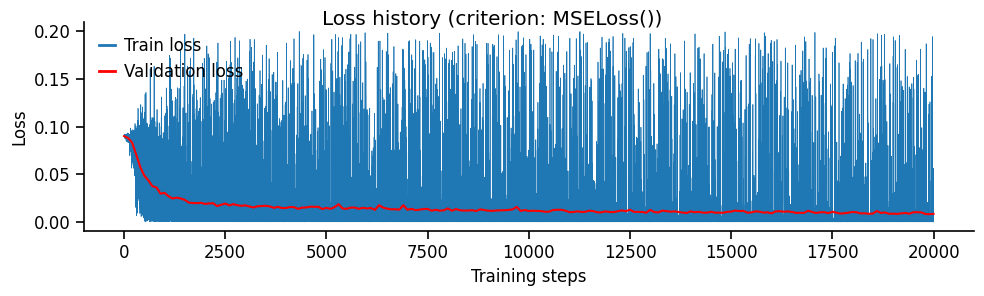

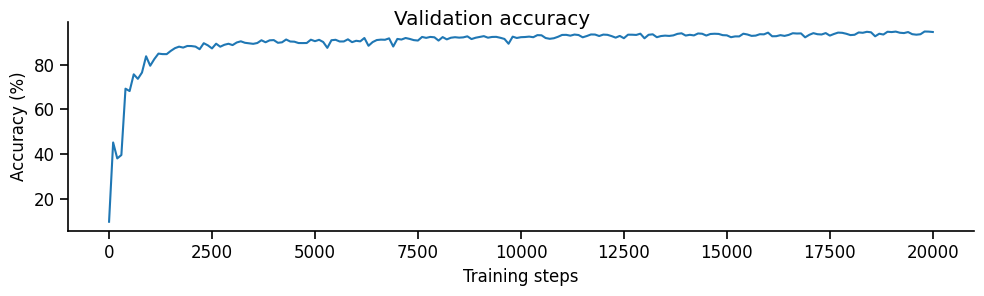

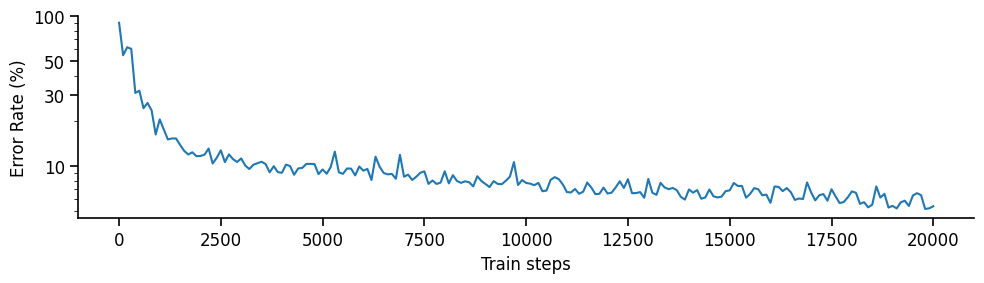

In [4]:
# Training parameters
# --------------------------
epochs = 1
train_steps = 20_000

# Train the network
# --------------------------
data_seed = 123 # Random seed for reproducibility. Ensures that the data is sampled in the same order each time.
data_generator.manual_seed(data_seed)
network.train(train_dataloader, val_dataloader, 
              epochs=epochs,
              samples_per_epoch=train_steps, 
              val_interval=(0, -1, 100), # Validation interval: (start, end, interval); Determines when to measure validation loss.
              status_bar=True)

# Plot training results
# --------------------------
eiann.plot.plot_loss_history(network)
eiann.plot.plot_accuracy_history(network)
eiann.plot.plot_error_history(network)

We can save the trained network to a [pickle](https://dill.readthedocs.io/en/latest/index.html) file for later analysis or checkpoint training:

In [5]:
network_name = "example_feedforward_ANN"
ut.save_network(network, path= f"{root_dir}/EIANN/saved_networks/mnist/{network_name}.pkl", overwrite=True)

Saved network to '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_feedforward_ANN.pkl'


At a later time, we can then load our trained model and either continue training it or use it to analyze the learned representations and internal structure of the network.

In [6]:
# Load network object from pickle file
network = ut.load_network(path= f"{root_dir}/EIANN/saved_networks/mnist/{network_name}.pkl")

Loading network from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_feedforward_ANN.pkl'
Network successfully loaded from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_feedforward_ANN.pkl'


## 3. Build and train a recurrent network with separate E and I cells

We can also do the same thing for biologically constrained (Dale's law) networks with more complex recurrent dynamics between their E and I populations.

In [7]:
network_config = eiann.NetworkBuilder()

# Define layers and populations
network_config.layer('Input').population('E', 784)
network_config.layer('H1').population('E', 500, 'relu').population('SomaI', 50, 'relu', tau=2)#, bias=True)
network_config.layer('H2').population('E', 500, 'relu').population('SomaI', 50, 'relu', tau=2)#, bias=True)
network_config.layer('Output').population('E', 10, 'relu').population('SomaI', 10, 'relu', tau=2)#, bias=True)

# Create connections between populations
network_config.connect(source='Input.E', target='H1.E').type('Exc')
network_config.connect(source='H1.E', target='H1.SomaI').type('Exc',init_scale=0.2).direction('F') 
network_config.connect(source='H1.SomaI', target='H1.E').type('Inh').direction('R')

network_config.connect(source='H1.E', target='H2.E').type('Exc')
network_config.connect(source='H2.E', target='H2.SomaI').type('Exc',init_scale=0.1).direction('F')
network_config.connect(source='H2.SomaI', target='H2.E').type('Inh').direction('R')

network_config.connect(source='H2.E', target='Output.E').type('Exc') 
network_config.connect(source='Output.E', target='Output.SomaI').type('Exc', init_scale=0.08).direction('F')
network_config.connect(source='Output.SomaI', target='Output.E').type('Inh').direction('R')

# Set global learning rule
network_config.set_learning_rule('Backprop')

# Set training parameters
network_config.training(optimizer='Adam',
                        tau=3,
                        forward_steps=18,
                        backward_steps=3,
                        learning_rate=0.0001)

network_config.print_architecture()

# Build the network
network_seed = 42 # Random seed for network initialization (for reproducibility)
network = network_config.build(seed=network_seed)


Network Architecture:
Input.E (784) -> H1.E (500) [Exc]: Backprop
H1.SomaI (50) -> H1.E (500) [Inh]: Backprop
H1.E (500) -> H1.SomaI (50) [Exc]: Backprop
H1.E (500) -> H2.E (500) [Exc]: Backprop
H2.SomaI (50) -> H2.E (500) [Inh]: Backprop
H2.E (500) -> H2.SomaI (50) [Exc]: Backprop
H2.E (500) -> Output.E (10) [Exc]: Backprop
Output.SomaI (10) -> Output.E (10) [Inh]: Backprop
Output.E (10) -> Output.SomaI (10) [Exc]: Backprop

Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (H1E_H1SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H1SomaI_H1E): Projection(in_features=500, out_features=50, bias=False)
    (H2E_H1E): Projection(in_features=500, out_features=500, bias=False)
    (H2E_H2SomaI): Projection(in_features=50, out_features=500, bias=False)
    (H2SomaI_H2E): Projection(in_features=500, out_features=50, bias=False)
    (OutputE_H2E): Projection(in_features=500, out_fea

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

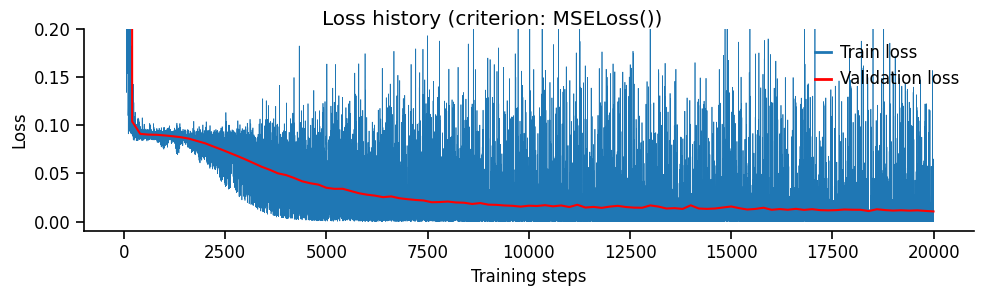

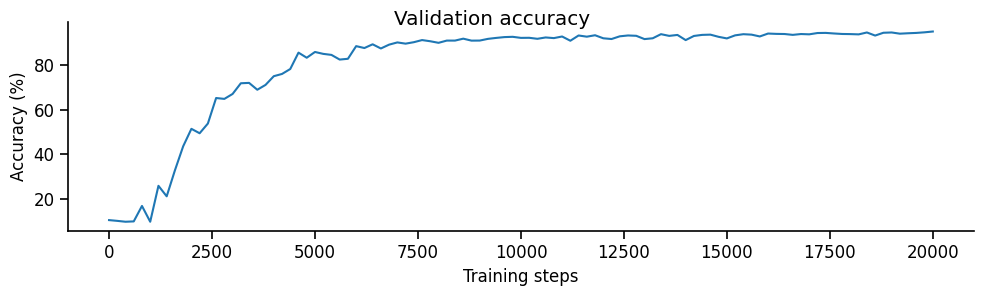

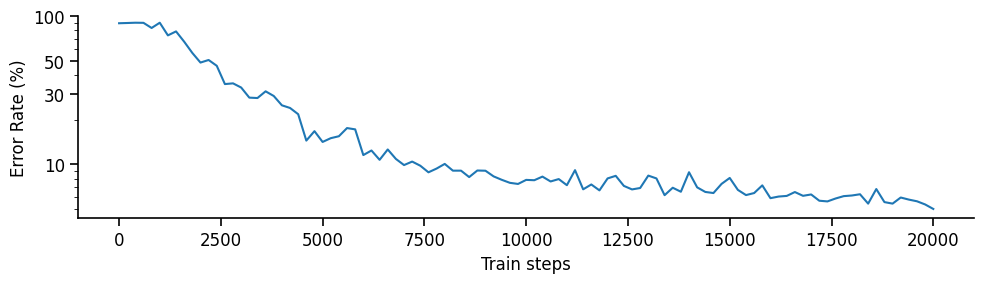

In [8]:
# Training parameters
# --------------------------
epochs = 1
train_steps = 20_000

# Train the network
# --------------------------
data_seed = 123 # Random seed for reproducibility. Ensures that the data is sampled in the same order each time.
data_generator.manual_seed(data_seed)
network.train(train_dataloader, val_dataloader, 
              epochs=epochs,
              samples_per_epoch=train_steps, 
              val_interval=(0, -1, 200), # Validation interval: (start, end, interval); Determines when to measure validation loss.
              status_bar=True)

# Plot training results
# --------------------------
eiann.plot.plot_loss_history(network, ylim=(-0.01, 0.2))
eiann.plot.plot_accuracy_history(network)
eiann.plot.plot_error_history(network)

In [9]:
network_name = "example_EI_network"
ut.save_network(network, path= f"{root_dir}/EIANN/saved_networks/mnist/{network_name}.pkl", overwrite=True)

Saved network to '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/saved_networks/mnist/example_EI_network.pkl'


In the next tutorial, we will see a more in-depth example of what we can analyze about the internal structure of a trained EIANN network.